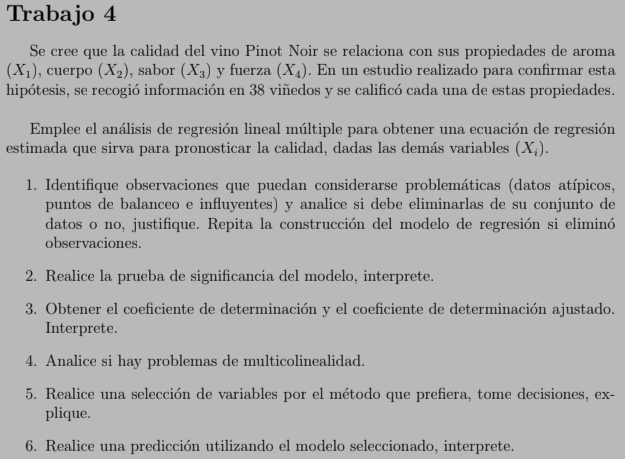

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

data = pd.read_csv('Base Trabajo4 20252.txt', sep='\t')

X = data[['aroma', 'cuerpo', 'sabor', 'fuerza']]
X = sm.add_constant(X)
y = data['calidad']
n = data.shape[0]
k = data.shape[1] - 1

modelo = sm.OLS(y, X).fit()
print(modelo.summary()) # Valores P muy altos, no son variables significativas para el modelo

# A simple vista la variable cuerpo parece no tener una relación lineal con la variable respuesta lo cual me indica que no es significativa para mi modelo 

                            OLS Regression Results                            
Dep. Variable:                calidad   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     19.81
Date:                Tue, 30 Sep 2025   Prob (F-statistic):           2.14e-08
Time:                        16:37:28   Log-Likelihood:                -57.158
No. Observations:                  38   AIC:                             124.3
Df Residuals:                      33   BIC:                             132.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3173      1.473      4.289      0.0

## Punto 1

In [2]:
# Identificacion de observaciones atipicas e influyentes

influence = modelo.get_influence()

SSE = modelo.ssr # Suma de los residuos al cuadrado.
df_error = modelo.df_resid # Grados de libertad de los residuos en el modelo ---> ( n - (k + 1))
MSE = modelo.mse_resid # Error cuadrático medio de los residuos.

residuales_estandarizados = modelo.resid / np.sqrt(MSE) # Residuales estandarizados
residuales_estudentizados = influence.resid_studentized_internal # Residuales studentizados

obs_atipicas = (abs(residuales_estandarizados) > 3).sum() # Identificamos observaciones atipicas mediante residuales estandarizados
obs_atipicas_studentizados = (abs(residuales_estudentizados) > 3).sum() # Identificamos observaciones atipicas mediante residuales estudentizados

matriz_hat_Hii = influence.hat_matrix_diag # matriz_hat_Hii
criterio = 2 * (k + 1) / n


obs_influyentes = (matriz_hat_Hii > criterio).sum() # Identificamos dos (2) observaciones posiblemente influyentes mediante la matriz Hat ( Puntos de balanceo )

dist_cook = (influence.cooks_distance[0] > 1).sum() # Identificamos que no tenemos observaciones que impacten coeficientes del modelo mediante la Distancia de Cook

dffits = (abs(influence.dffits[0]) > 2 * np.sqrt((k+1) / n)) # Identificamos que tenemos una observacion que impacta en el modelo mediante DFFITS

index_puntos_influyentes = data.index[dffits] # La observacion numero 19 es la influyente segun DFFITS

data_filtered = data.drop(index_puntos_influyentes) # Eliminamos la observacion que identificamos como influyente para crear una nueva data

X_filtered = data_filtered[['aroma', 'cuerpo','sabor','fuerza']]
X_filtered = sm.add_constant(X_filtered)
y_filtered = data_filtered['calidad']

modelo_filtered = sm.OLS(y_filtered, X_filtered).fit()

print('\nResumen del modelo OLS despues de excluir puntos influyentes')
print(modelo_filtered.summary())


Resumen del modelo OLS despues de excluir puntos influyentes
                            OLS Regression Results                            
Dep. Variable:                calidad   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     21.23
Date:                Tue, 30 Sep 2025   Prob (F-statistic):           1.25e-08
Time:                        16:37:28   Log-Likelihood:                -52.066
No. Observations:                  37   AIC:                             114.1
Df Residuals:                      32   BIC:                             122.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

## Punto 2

In [3]:
# Significancia del modelo con la prueba F

# Hipotesis

# Ho: B1 = B2 = B3 = B4 = 0  vs  Ha: Bj != 0 

f_pvalue = modelo_filtered.f_pvalue 
f_estadistico = modelo_filtered.fvalue
alfa = 0.05

if f_pvalue < alfa:
    print(f'El valor P del modelo ({f_pvalue:.10f}) es mucho menor que {alfa} por lo que rechazamos la Ho y concluimos que el modelo en conjunto es bastante significativo')
else :
    print(f'Dado que {f_pvalue} es mayor a {alfa} no rechazamos la Ho y concluimos que el modelo en conjunto no es significativo')


# Significancia individual de los coeficientes con la prueba T

# Ho: Bj = 0  vs  Ha: Bj != 0

t_pvalue_aroma = modelo_filtered.pvalues['aroma']
t_value_cuerpo = modelo_filtered.pvalues['cuerpo']
t_value_sabor = modelo_filtered.pvalues['sabor']
t_value_fuerza = modelo_filtered.pvalues['fuerza']

print(t_pvalue_aroma, t_value_cuerpo, t_value_sabor, t_value_fuerza)

if t_pvalue_aroma < alfa:
    print(f'El valor P de la variable aroma es {t_pvalue_aroma}, por lo que esta justo al limite de significancia {alfa}. Podemos concluir que esta variable es debilmente significativa')
else:
    print(f'El valor P de la variable aroma es {t_pvalue_aroma}, por lo que esta justo al limite de significancia {alfa}. Podemos concluir que esta variable es debilmente significativa')

if t_value_cuerpo < alfa:
    print(f'El valor P de la variable cuerpo es {t_value_cuerpo}, esto es menor que la significancia {alfa}. Podemos concluir que esta variable es significativa')
else:
    print(f'El valor P de la variable cuerpo es {t_value_cuerpo}, esto es mayor que la significancia {alfa}. Podemos concluir que esta variable no parece explicar de forma independiente la variacion en calidad')

if t_value_sabor < alfa:
    print(f'El valor P de la variable sabor es {t_value_sabor}, esto es menor que la significancia {alfa}. Podemos concluir que esta variable es altamente significativa')
else:
    print(f'El valor P de la variable sabor es {t_value_sabor}, esto es mayor que la significancia {alfa}. Podemos concluir que esta variable NO es significativa')

if t_value_fuerza < alfa:
    print(f'El valor P de la variable fuerza es {t_value_fuerza}, esto es menor que la significancia {alfa}. Podemos concluir que esta variable es significativa')
else:
    print(f'El valor P de la variable fuerza es {t_value_fuerza}, esto es mayor que la significancia {alfa}. Podemos concluir que esta variable NO es significativa')


# Cuando sacamos la observacion numero 19 de nuestros datos nos damos cuenta que el valor P de la variable cuerpo bajo de 0.749 a 0.242 pero aun asi sigue siendo no significativa. No parece explicar de forma independiente la variación en calidad.

El valor P del modelo (0.0000000125) es mucho menor que 0.05 por lo que rechazamos la Ho y concluimos que el modelo en conjunto es bastante significativo
0.05003458058424405 0.24170541751238572 0.0017406310317731252 0.005908033996194086
El valor P de la variable aroma es 0.05003458058424405, por lo que esta justo al limite de significancia 0.05. Podemos concluir que esta variable es debilmente significativa
El valor P de la variable cuerpo es 0.24170541751238572, esto es mayor que la significancia 0.05. Podemos concluir que esta variable no parece explicar de forma independiente la variacion en calidad
El valor P de la variable sabor es 0.0017406310317731252, esto es menor que la significancia 0.05. Podemos concluir que esta variable es altamente significativa
El valor P de la variable fuerza es 0.005908033996194086, esto es menor que la significancia 0.05. Podemos concluir que esta variable es significativa


## Punto 3

In [4]:
coef_det = modelo_filtered.rsquared
coef_det_adj = modelo_filtered.rsquared_adj

print(f'Coeficiente de determinacion ( R2 ) es de {coef_det:.4f} lo cual indica que el modelo explica el {(coef_det * 100):.2f}% de la variabilidad en calidad.')
print(f'Coeficiente de determinacion ajustado ( R2 adj ) es de {coef_det_adj:.4f} lo cual indica que el modelo explica el {(coef_det_adj * 100):.2f}% de la variabilidad en calidad.')

Coeficiente de determinacion ( R2 ) es de 0.7263 lo cual indica que el modelo explica el 72.63% de la variabilidad en calidad.
Coeficiente de determinacion ajustado ( R2 adj ) es de 0.6921 lo cual indica que el modelo explica el 69.21% de la variabilidad en calidad.


## Punto 4

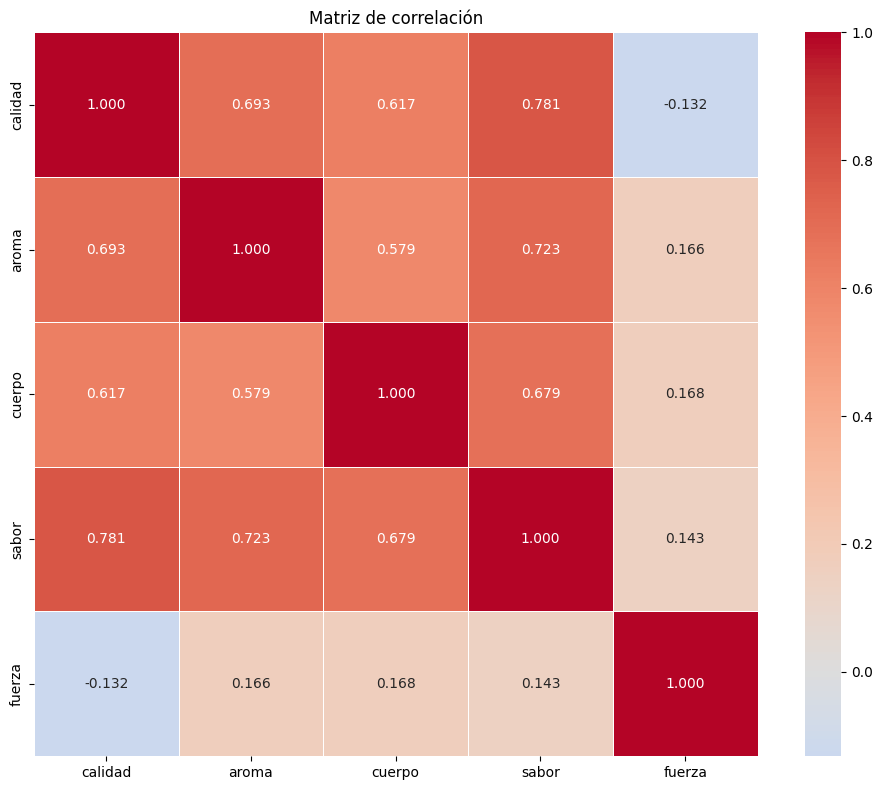

Hacemos un pairplot para obtener un poco mas de informacion


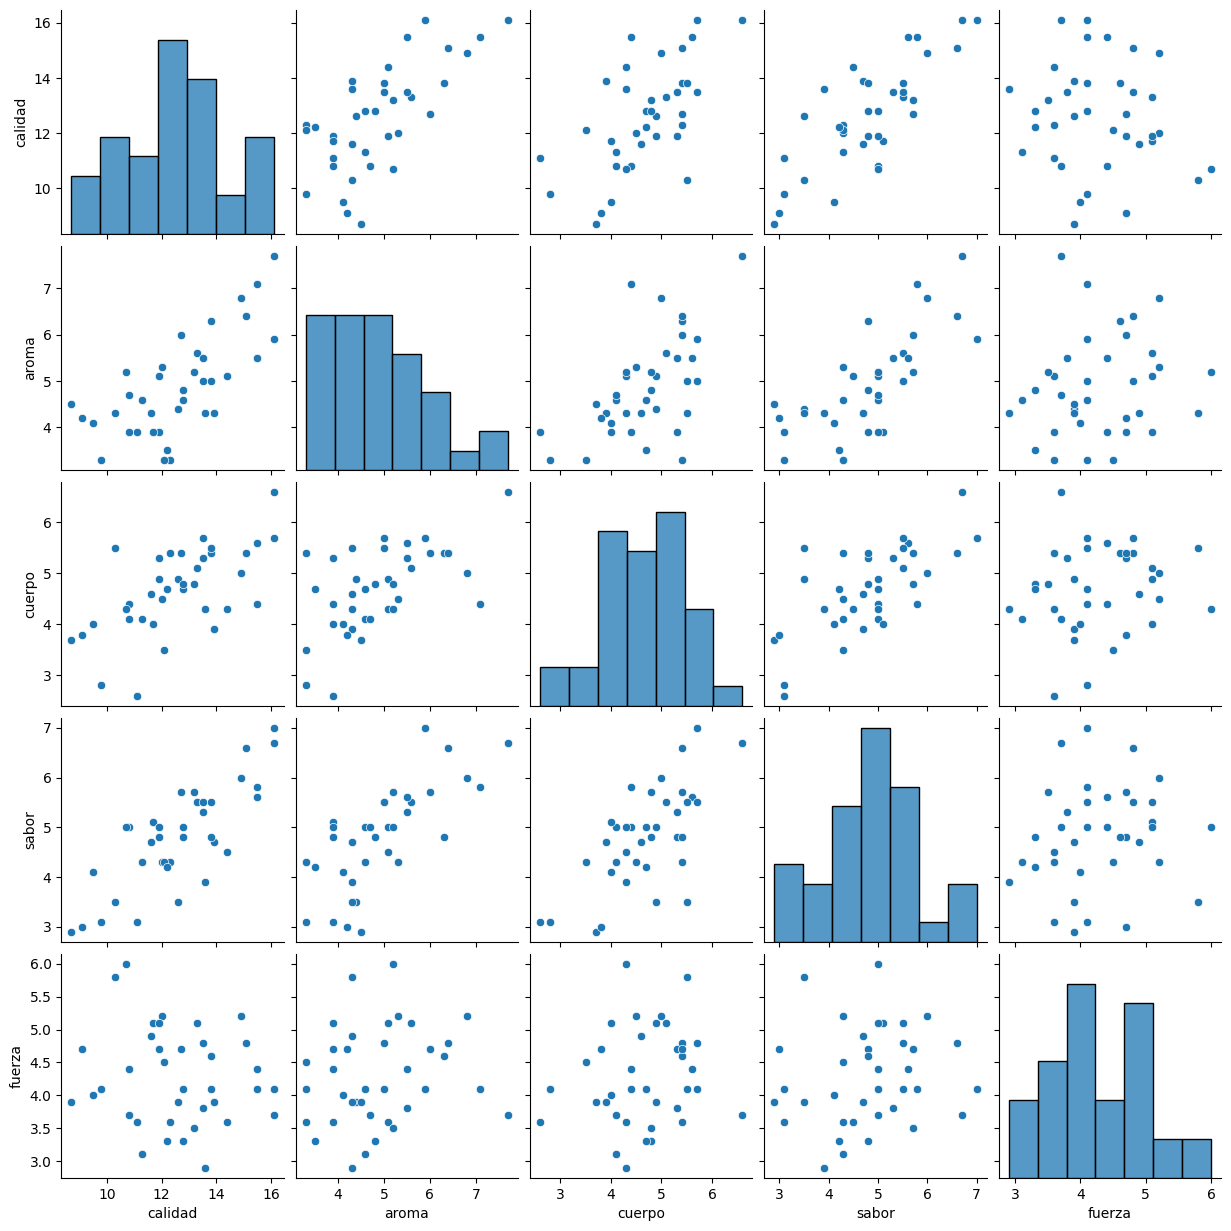

Hasta aqui hemos identificado un indicio de multicolinealidad entre las variables Aroma vs Sabor vs Cuerpo


In [5]:
# Matriz de correlaciones

corr_matrix = data_filtered.corr()

# Grafico de matriz de dispersion

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, center=0, square=True, fmt='.3f')
plt.title('Matriz de correlación')
plt.tight_layout()
plt.show()

print('Hacemos un pairplot para obtener un poco mas de informacion')
sns.pairplot(data_filtered)
plt.show()

print('Hasta aqui hemos identificado un indicio de multicolinealidad entre las variables Aroma vs Sabor vs Cuerpo')

In [6]:
def calcular_vif(X):
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif
print('Vamos mas a fondo y usamos VIF ( Factor de Inflacion de Varianza ) para identificar hay multicolinealidad o no.\n')
vif_result = calcular_vif(X_filtered.drop('const', axis=1))
print(vif_result)
print('\nLos valores VIF para cada variable son mucho mayores a 10 por lo cual tenemos mas datos que evidencian la presencia de multicolinealidad severa en nuestro modelo.')

print('\nOtra forma de revisar multicolinealidad es: Analizando Valores propios.')


matriz_designada = X_filtered.T.dot(X_filtered)
valores_propios = np.linalg.eigvals(matriz_designada)

num_condicion = (valores_propios.max() / valores_propios.min())
print(f'\nEl numero de condicion (k): {num_condicion:.2f} es mayor a 1000 por lo cual seguimos corroborando que existe multicolinealidad severa en nuestro modelo.')

indice_condicion = np.sqrt(valores_propios.max() / valores_propios)

for i in indice_condicion[1:]:
    if i <= 10:
        print(f'\nPara el valor propio {i:.2f}: No hay problemas de multicolinealidad.')
    elif i > 10 and i <= 31.6:
        print(f'\nPara el valor propio {i:.2f}: Existe una colinealidad moderada.')
    else:
        print(f'\nPara el valor propio {i:.2f}: Existe una multicolinealidad severa.')


Vamos mas a fondo y usamos VIF ( Factor de Inflacion de Varianza ) para identificar hay multicolinealidad o no.

  Variable        VIF
0    aroma  48.279894
1   cuerpo  56.741949
2    sabor  63.662086
3   fuerza  22.359130

Los valores VIF para cada variable son mucho mayores a 10 por lo cual tenemos mas datos que evidencian la presencia de multicolinealidad severa en nuestro modelo.

Otra forma de revisar multicolinealidad es: Analizando Valores propios.

El numero de condicion (k): 5535.43 es mayor a 1000 por lo cual seguimos corroborando que existe multicolinealidad severa en nuestro modelo.

Para el valor propio 11.00: Existe una colinealidad moderada.

Para el valor propio 74.40: Existe una multicolinealidad severa.

Para el valor propio 15.70: Existe una colinealidad moderada.

Para el valor propio 19.40: Existe una colinealidad moderada.


## Punto 5

In [7]:
def forward_selection_r2_adj(X, y):

    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    
    remaining_vars = list(X.columns)
    selected_vars = []
    current_r2_adj = -np.inf 
    
    print("--- Proceso de Selección Forward (Criterio: R2 Ajustado) ---")
    
    X_base = sm.add_constant(pd.DataFrame({'const': [1] * len(y)}))
    model_base = sm.OLS(y, X_base).fit()
    current_r2_adj = model_base.rsquared_adj
    print(f"R2 Ajustado Base (Solo Intercepto): {current_r2_adj:.4f}")

    while remaining_vars:
        best_improvement = -np.inf
        best_feature = None
        best_model = None
        
        for feature in remaining_vars:
            current_vars = selected_vars + [feature]
            
            X_model = sm.add_constant(X[current_vars]) 
            model = sm.OLS(y, X_model).fit()
            
            new_r2_adj = model.rsquared_adj
            improvement = new_r2_adj - current_r2_adj

            if improvement > best_improvement:
                best_improvement = improvement
                best_feature = feature
                best_model = model
                best_new_r2_adj = new_r2_adj

        if best_improvement > 0:
            selected_vars.append(best_feature)
            remaining_vars.remove(best_feature)
            current_r2_adj = best_new_r2_adj 
            
            print(f"\nPASO: Añadida '{best_feature}'. Mejora R2: {best_improvement:.4f}. Nuevo R2 Ajustado: {current_r2_adj:.4f}")
        else:
            print(f"\nPARADA: No quedan variables restantes o ninguna variable restante aumenta el R2 Ajustado del modelo actual.")
            break

    if selected_vars:
        return selected_vars, best_model.summary()
    else:
        return [], model_base.summary()


selected_features, final_model_summary = forward_selection_r2_adj(X_filtered, y_filtered)

print("\n" + "="*70)
print(f"VARIABLES SELECCIONADAS (Forward con R2 Ajustado): {selected_features}")
print("\n--- Resumen Estadístico del Mejor Modelo ---")
print(final_model_summary)
print("="*70)

--- Proceso de Selección Forward (Criterio: R2 Ajustado) ---
R2 Ajustado Base (Solo Intercepto): 0.0000

PASO: Añadida 'sabor'. Mejora R2: 0.5984. Nuevo R2 Ajustado: 0.5984

PASO: Añadida 'fuerza'. Mejora R2: 0.0525. Nuevo R2 Ajustado: 0.6509

PASO: Añadida 'aroma'. Mejora R2: 0.0373. Nuevo R2 Ajustado: 0.6882

PASO: Añadida 'cuerpo'. Mejora R2: 0.0039. Nuevo R2 Ajustado: 0.6921

PARADA: No quedan variables restantes o ninguna variable restante aumenta el R2 Ajustado del modelo actual.

VARIABLES SELECCIONADAS (Forward con R2 Ajustado): ['sabor', 'fuerza', 'aroma', 'cuerpo']

--- Resumen Estadístico del Mejor Modelo ---
                            OLS Regression Results                            
Dep. Variable:                calidad   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     21.23
Date:                Tue, 30 Sep 2025   Prob (F-statisti

Podemos notar que la variable cuerpo al agregarla mejora el R2 ajustado de nuestro modelo en 0.0039 lo cual consideramos muy bajo y preferiremos en este caso no añadirla

In [8]:
try:
    X_filtered = X_filtered.drop(columns=['cuerpo'], axis=1)
    print("Columna 'cuerpo' eliminada de X_filtered.")
except KeyError:
    X_filtered = X_filtered.copy()
    print("La columna 'cuerpo' no se encontró o ya fue eliminada.")

X_modelo_final = X_filtered.reset_index(drop=True)
y_modelo_final = y_filtered.reset_index(drop=True)

X_modelo_final = sm.add_constant(X_modelo_final)

modelo_final = sm.OLS(y_modelo_final, X_modelo_final).fit()

print(modelo_final.summary())

variables_finales = list(X_filtered.columns)
print(f"\nVariables Finales del Modelo: {variables_finales}")

Columna 'cuerpo' eliminada de X_filtered.
                            OLS Regression Results                            
Dep. Variable:                calidad   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     27.48
Date:                Tue, 30 Sep 2025   Prob (F-statistic):           4.25e-09
Time:                        16:37:30   Log-Likelihood:                -52.871
No. Observations:                  37   AIC:                             113.7
Df Residuals:                      33   BIC:                             120.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const     

## Punto 6

In [9]:
prediccion = modelo_final.predict(X_modelo_final)
prediccion, y_modelo_final
df_prediccion_vs_realidad = pd.DataFrame({
    'Prediccion': prediccion.round(2),  # Nuevos valores de aroma
    'Realidad': y_modelo_final})

df_prediccion_vs_realidad

,Prediccion,Realidad
0,9.90,9.8
1,11.09,12.6
2,11.73,11.9
3,10.58,11.1
4,13.16,13.3
5,12.75,12.8
6,13.20,12.8
7,11.57,12.0
8,12.19,13.6
9,12.39,13.9
